In [2]:
# %%

import pandas as pd
import numpy as np
from sklearn.svm import SVR
# from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, reciprocal
# from common.preprocessor import load_data
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
%matplotlib inline

In [5]:
# %%
data = pd.read_csv('../Modified_Data.csv', parse_dates=True, index_col=[0])

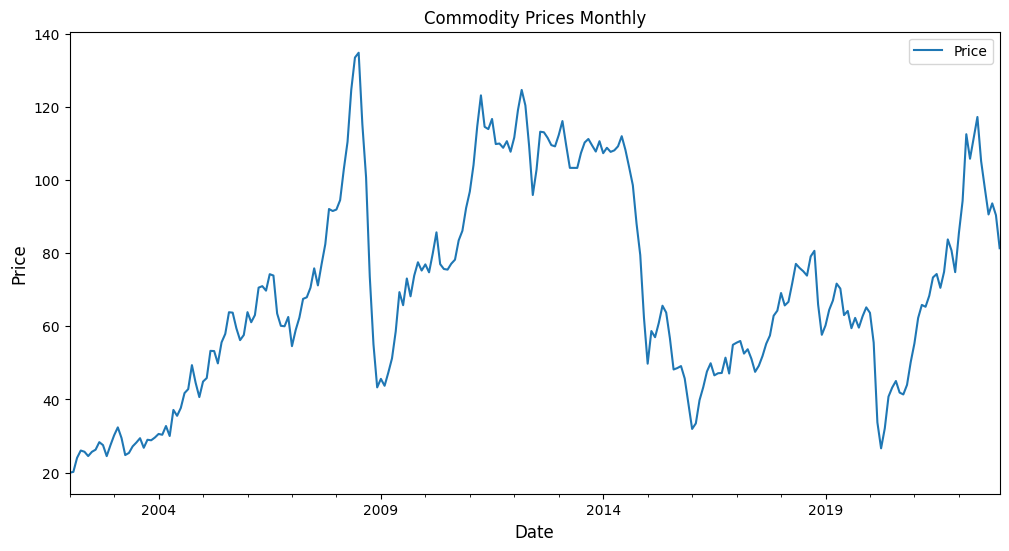

In [6]:
# %%

data.plot(y='Price', title='Commodity Prices Monthly', figsize=(12, 6))
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()

In [7]:
# %%

# set the train and test data with start dates
train_start_date = '2002-01-01'
test_start_date = '2019-01-01'

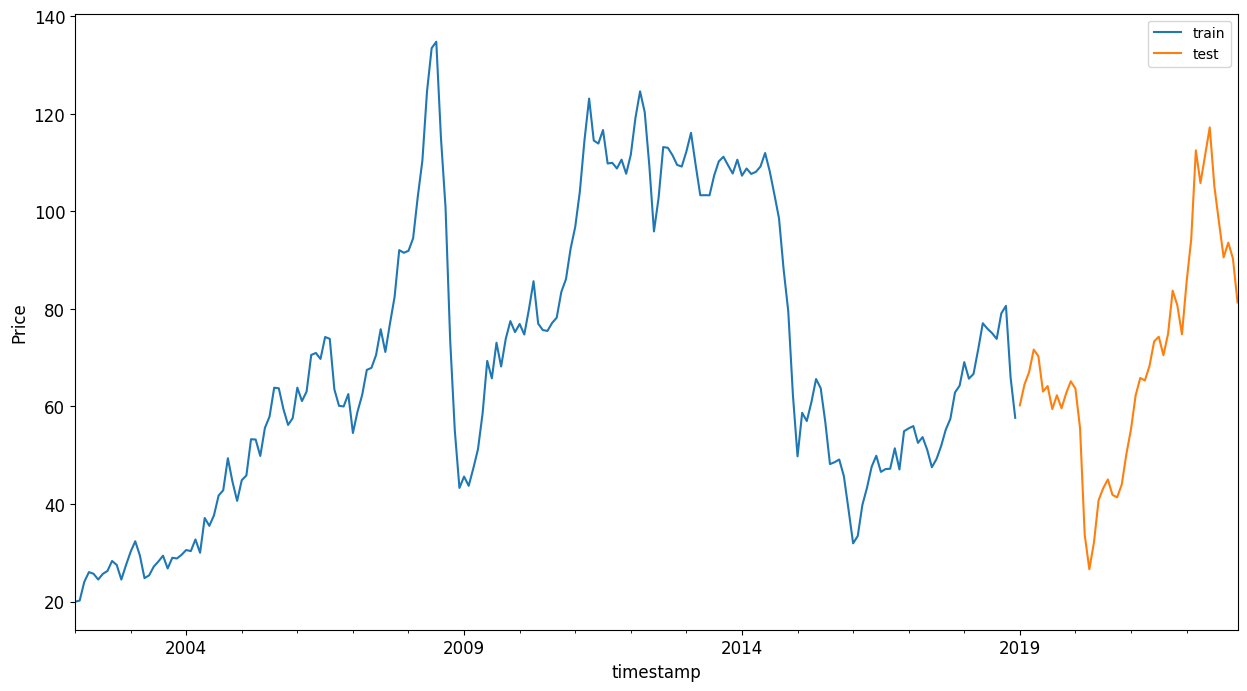

In [8]:
# %%

# visualize the train and test data
data[(data.index < test_start_date) & (data.index >= train_start_date)][['Price']].rename(columns={'Price':'train'}) \
    .join(data[test_start_date:][['Price']].rename(columns={'Price':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()

In [9]:
# %%

# set the train and test data and print the dimensions of it
train = data.copy()[(data.index >= train_start_date) & (data.index < test_start_date)][['Price']]
test = data.copy()[data.index >= test_start_date][['Price']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (204, 1)
Test data shape:  (48, 1)


In [10]:
# %%

# Prepare data for training
scaler = MinMaxScaler()
scaled_train = train.copy()
scaled_test = test.copy()
scaled_train['Price'] = scaler.fit_transform(scaled_train[['Price']])
scaled_test['Price'] = scaler.transform(scaled_test[['Price']])  # Scale the test data
print(f'Scaled Training Set: {scaled_train.shape}\nScaled Testing Set {scaled_test.shape}')

Scaled Training Set: (204, 1)
Scaled Testing Set (48, 1)


In [11]:
# %%

# Convert to numpy arrays
scaled_train_data = scaled_train.values
scaled_test_data = scaled_test.values

In [12]:
# %%

timesteps = 3

In [13]:
# %%

scaled_train_data_timesteps=np.array([[j for j in scaled_train_data[i:i+timesteps]] for i in range(0,len(scaled_train_data)-timesteps+1)])[:,:,0]
scaled_train_data_timesteps.shape

(202, 3)

In [14]:
# %%

scaled_train_data

array([[0.        ],
       [0.00200296],
       [0.0354437 ],
       [0.05286075],
       [0.04989985],
       [0.03962379],
       [0.04972568],
       [0.05486371],
       [0.07280327],
       [0.06574937],
       [0.03953671],
       [0.06522686],
       [0.08900113],
       [0.10798572],
       [0.08264391],
       [0.04206218],
       [0.04711312],
       [0.06270138],
       [0.07184534],
       [0.08220848],
       [0.05939214],
       [0.07846382],
       [0.07724462],
       [0.08377602],
       [0.09231037],
       [0.0903945 ],
       [0.11120787],
       [0.0874336 ],
       [0.14952539],
       [0.13550466],
       [0.15422799],
       [0.1895846 ],
       [0.1990769 ],
       [0.25620482],
       [0.21414265],
       [0.18009231],
       [0.21701646],
       [0.22546373],
       [0.29016807],
       [0.28964556],
       [0.26029783],
       [0.31037185],
       [0.33066272],
       [0.38213011],
       [0.38108508],
       [0.34381259],
       [0.31568405],
       [0.327

In [15]:
# %%

scaled_test_data_timesteps=np.array([[j for j in scaled_test_data[i:i+timesteps]] for i in range(0,len(scaled_test_data)-timesteps+1)])[:,:,0]
scaled_test_data_timesteps.shape

(46, 3)

In [16]:
# %%

X_train, y_train = scaled_train_data_timesteps[:,:timesteps-1],scaled_train_data_timesteps[:,[timesteps-1]]
X_test, y_test = scaled_test_data_timesteps[:,:timesteps-1],scaled_test_data_timesteps[:,[timesteps-1]]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(202, 2) (202, 1)
(46, 2) (46, 1)


In [17]:
# %%

SVR??

Init signature:
SVR(
    *,
    kernel='rbf',
    degree=3,
    gamma='scale',
    coef0=0.0,
    tol=0.001,
    C=1.0,
    epsilon=0.1,
    shrinking=True,
    cache_size=200,
    verbose=False,
    max_iter=-1,
)
Source:        
class SVR(RegressorMixin, BaseLibSVM):
    """Epsilon-Support Vector Regression.

    The free parameters in the model are C and epsilon.

    The implementation is based on libsvm. The fit time complexity
    is more than quadratic with the number of samples which makes it hard
    to scale to datasets with more than a couple of 10000 samples. For large
    datasets consider using :class:`~sklearn.svm.LinearSVR` or
    :class:`~sklearn.linear_model.SGDRegressor` instead, possibly after a
    :class:`~sklearn.kernel_approximation.Nystroem` transformer or
    other :ref:`kernel_approximation`.

    Read more in the :ref:`User Guide <svm_regression>`.

    Parameters
    ----------
    kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable,  \

In [18]:
# %%

svr = SVR()

In [19]:
# %%

param_distributions = {
    'C': uniform(1, 10),  # Regularization parameter
    'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5],  # Margin of tolerance
    'gamma': reciprocal(0.001, 0.1),  # Kernel coefficient
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']  # Kernel type
}

# Perform randomized search
rnd_search_cv = RandomizedSearchCV(svr, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train, y_train)

# Print the best parameters
print(f"Best parameters: {rnd_search_cv.best_params_}")

# Fit and predict with the best parameters
best_svr = rnd_search_cv.best_estimator_
best_svr.fit(X_train, y_train)
y_pred = best_svr.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END C=10.00360475566228, epsilon=0.2, gamma=0.031650751586159924, kernel=poly; total time=   0.0s
[CV] END C=10.00360475566228, epsilon=0.2, gamma=0.031650751586159924, kernel=poly; total time=   0.0s
[CV] END C=10.00360475566228, epsilon=0.2, gamma=0.031650751586159924, kernel=poly; total time=   0.0s
[CV] END C=8.065777703285727, epsilon=0.5, gamma=0.002975195987112901, kernel=rbf; total time=   0.0s
[CV] END C=8.065777703285727, epsilon=0.5, gamma=0.002975195987112901, kernel=rbf; total time=   0.0s
[CV] END C=8.065777703285727, epsilon=0.5, gamma=0.002975195987112901, kernel=rbf; total time=   0.0s
[CV] END C=8.124130857671185, epsilon=0.2, gamma=0.04421832294821055, kernel=rbf; total time=   0.0s
[CV] END C=8.124130857671185, epsilon=0.2, gamma=0.04421832294821055, kernel=rbf; total time=   0.0s
[CV] END C=8.124130857671185, epsilon=0.2, gamma=0.04421832294821055, kernel=rbf; total time=   0.0s
[CV] END C=1.73626751

d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\utils\validation.py:1229: D

In [20]:
# %%

# Inverse transform the scaled data
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_pred_inv

array([[ 69.53686954],
       [ 71.47066124],
       [ 74.28433092],
       [ 74.17929211],
       [ 70.11223288],
       [ 69.74792107],
       [ 67.38385257],
       [ 68.25760986],
       [ 67.21613628],
       [ 68.50261861],
       [ 70.22573589],
       [ 69.7540869 ],
       [ 65.22056539],
       [ 52.72778455],
       [ 46.41397276],
       [ 48.36706366],
       [ 53.46336462],
       [ 55.80832824],
       [ 57.05517209],
       [ 55.62937128],
       [ 54.96806474],
       [ 56.2670718 ],
       [ 59.864239  ],
       [ 63.3517996 ],
       [ 67.69873751],
       [ 70.52475835],
       [ 70.73088219],
       [ 72.27268626],
       [ 75.36631302],
       [ 76.55294072],
       [ 74.64946694],
       [ 76.48335717],
       [ 81.85871066],
       [ 81.45925081],
       [ 77.83910491],
       [ 82.78116868],
       [ 89.00870392],
       [100.06890787],
       [ 98.96028188],
       [101.13726997],
       [104.96753154],
       [ 99.24060736],
       [ 93.5936656 ],
       [ 88

In [21]:
# %%

# plot with plotly
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=test.index[timesteps-1:], y=y_test.flatten(), mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=test.index[timesteps-1:], y=y_pred, mode='lines', name='Predicted'))
fig.update_layout(title='Actual vs Predicted', xaxis_title='Date', yaxis_title='Price')
fig.show()

In [22]:
# %%

# Random Forest Regressor
rf = RandomForestRegressor()

# Define the hyperparameters for the Random Forest
param_distributions_rf = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(1, 10),
    'min_samples_split': uniform(0.01, 0.2),
    'min_samples_leaf': uniform(0.01, 0.2),
}

# Perform randomized search for Random Forest
rnd_search_cv_rf = RandomizedSearchCV(rf, param_distributions_rf, n_iter=10, verbose=2, cv=3)
rnd_search_cv_rf.fit(X_train, y_train)

# Print the best parameters for Random Forest
print(f"Random Forest - Best parameters: {rnd_search_cv_rf.best_params_}")

# Fit and predict with the best parameters for Random Forest
best_rf = rnd_search_cv_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Calculate the MAE and MAPE for Random Forest
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
print(f"Random Forest - MAE: {mae_rf}\nRandom Forest - MAPE: {mape_rf}")

fig = go.Figure()
fig.add_trace(go.Scatter(x=test.index[timesteps-1:], y=y_test.flatten(), mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=test.index[timesteps-1:], y=y_pred_rf, mode='lines', name='Random Forest'))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] END max_depth=2, min_samples_leaf=0.19129226434876545, min_samples_split=0.061572244989227684, n_estimators=483; total time=   0.7s


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] END max_depth=2, min_samples_leaf=0.19129226434876545, min_samples_split=0.061572244989227684, n_estimators=483; total time=   0.5s


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] END max_depth=2, min_samples_leaf=0.19129226434876545, min_samples_split=0.061572244989227684, n_estimators=483; total time=   0.5s
[CV] END max_depth=7, min_samples_leaf=0.03163257844130724, min_samples_split=0.1930109682924957, n_estimators=164; total time=   0.1s


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] END max_depth=7, min_samples_leaf=0.03163257844130724, min_samples_split=0.1930109682924957, n_estimators=164; total time=   0.2s
[CV] END max_depth=7, min_samples_leaf=0.03163257844130724, min_samples_split=0.1930109682924957, n_estimators=164; total time=   0.1s


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] END max_depth=2, min_samples_leaf=0.11917244153629324, min_samples_split=0.02363199962947872, n_estimators=120; total time=   0.2s


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] END max_depth=2, min_samples_leaf=0.11917244153629324, min_samples_split=0.02363199962947872, n_estimators=120; total time=   0.2s
[CV] END max_depth=2, min_samples_leaf=0.11917244153629324, min_samples_split=0.02363199962947872, n_estimators=120; total time=   0.1s


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] END max_depth=5, min_samples_leaf=0.106946417827696, min_samples_split=0.1936343830890918, n_estimators=382; total time=   0.5s


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] END max_depth=5, min_samples_leaf=0.106946417827696, min_samples_split=0.1936343830890918, n_estimators=382; total time=   0.4s


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] END max_depth=5, min_samples_leaf=0.106946417827696, min_samples_split=0.1936343830890918, n_estimators=382; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=0.09327458866319353, min_samples_split=0.1614544741557542, n_estimators=125; total time=   0.1s


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] END max_depth=5, min_samples_leaf=0.09327458866319353, min_samples_split=0.1614544741557542, n_estimators=125; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=0.09327458866319353, min_samples_split=0.1614544741557542, n_estimators=125; total time=   0.0s


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] END max_depth=4, min_samples_leaf=0.17373024844338536, min_samples_split=0.19935584790338134, n_estimators=337; total time=   0.4s


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] END max_depth=4, min_samples_leaf=0.17373024844338536, min_samples_split=0.19935584790338134, n_estimators=337; total time=   0.4s


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] END max_depth=4, min_samples_leaf=0.17373024844338536, min_samples_split=0.19935584790338134, n_estimators=337; total time=   0.5s


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] END max_depth=1, min_samples_leaf=0.047750967680688136, min_samples_split=0.19847101665858496, n_estimators=470; total time=   0.6s


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] END max_depth=1, min_samples_leaf=0.047750967680688136, min_samples_split=0.19847101665858496, n_estimators=470; total time=   0.5s


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] END max_depth=1, min_samples_leaf=0.047750967680688136, min_samples_split=0.19847101665858496, n_estimators=470; total time=   0.6s


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] END max_depth=7, min_samples_leaf=0.02342425365489812, min_samples_split=0.03159886169141508, n_estimators=231; total time=   0.2s


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] END max_depth=7, min_samples_leaf=0.02342425365489812, min_samples_split=0.03159886169141508, n_estimators=231; total time=   0.2s


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] END max_depth=7, min_samples_leaf=0.02342425365489812, min_samples_split=0.03159886169141508, n_estimators=231; total time=   0.3s


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] END max_depth=6, min_samples_leaf=0.051082792504360534, min_samples_split=0.14236746549551046, n_estimators=307; total time=   0.5s


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] END max_depth=6, min_samples_leaf=0.051082792504360534, min_samples_split=0.14236746549551046, n_estimators=307; total time=   0.5s


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] END max_depth=6, min_samples_leaf=0.051082792504360534, min_samples_split=0.14236746549551046, n_estimators=307; total time=   0.4s


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] END max_depth=2, min_samples_leaf=0.14023907419070353, min_samples_split=0.11888634783684081, n_estimators=321; total time=   0.4s


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] END max_depth=2, min_samples_leaf=0.14023907419070353, min_samples_split=0.11888634783684081, n_estimators=321; total time=   0.5s


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] END max_depth=2, min_samples_leaf=0.14023907419070353, min_samples_split=0.11888634783684081, n_estimators=321; total time=   0.5s


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Random Forest - Best parameters: {'max_depth': 7, 'min_samples_leaf': 0.02342425365489812, 'min_samples_split': 0.03159886169141508, 'n_estimators': 231}
Random Forest - MAE: 0.04519345180861382
Random Forest - MAPE: 0.1559667011576426


In [23]:
# %%

# XGBoost Regressor
xgb = XGBRegressor()

# Define the hyperparameters for XGBoost
param_distributions_xgb = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(1, 10),
    'learning_rate': uniform(0.01, 0.6),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
}

# Perform randomized search for XGBoost
rnd_search_cv_xgb = RandomizedSearchCV(xgb, param_distributions_xgb, n_iter=10, verbose=2, cv=3)
rnd_search_cv_xgb.fit(X_train, y_train)

# Print the best parameters for XGBoost
print(f"XGBoost - Best parameters: {rnd_search_cv_xgb.best_params_}")

# Fit and predict with the best parameters for XGBoost
best_xgb = rnd_search_cv_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# Calculate the MAE and MAPE for XGBoost
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
print(f"XGBoost - MAE: {mae_xgb}\nXGBoost - MAPE: {mape_xgb}")

# plot with plotly
# import plotly.graph_objects as go


fig.add_trace(go.Scatter(x=test.index[timesteps-1:], y=y_pred_xgb, mode='lines', name='XGBoost'))
fig.add_trace(go.Scatter(x=test.index[timesteps-1:], y=y_pred, mode='lines', name='SVR'))
fig.update_layout(title='Actual vs Predicted', xaxis_title='Date', yaxis_title='Price')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.973081750263415, learning_rate=0.11384021412444552, max_depth=2, n_estimators=380, subsample=0.6747244955113383; total time=   0.3s
[CV] END colsample_bytree=0.973081750263415, learning_rate=0.11384021412444552, max_depth=2, n_estimators=380, subsample=0.6747244955113383; total time=   0.1s
[CV] END colsample_bytree=0.973081750263415, learning_rate=0.11384021412444552, max_depth=2, n_estimators=380, subsample=0.6747244955113383; total time=   0.2s
[CV] END colsample_bytree=0.8594954661881546, learning_rate=0.3092927683702588, max_depth=4, n_estimators=457, subsample=0.6733396714790666; total time=   0.6s
[CV] END colsample_bytree=0.8594954661881546, learning_rate=0.3092927683702588, max_depth=4, n_estimators=457, subsample=0.6733396714790666; total time=   0.4s
[CV] END colsample_bytree=0.8594954661881546, learning_rate=0.3092927683702588, max_depth=4, n_estimators=457, subsample=0.6733396714790666